# Train a deep CNN on XPS data on Google Colab

In this notebook, we will train a deep convolutional network on iron XPS spectra using the local CPU/GPU.

## Setup

### Install packaged and import modules

In [4]:
# Import standard modules and magic commands
!pip install tensorflow==2.1.0
!pip install python-docx
import os
import datetime
import numpy as np
import pytz
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

# Disable tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Mount google drive, change working directory

In [5]:
# Mount drive
from getpass import getpass
import urllib
from google.colab import drive
drive.mount('/content/drive')

# Change working path
os.chdir(os.path.join(os.getcwd().partition('content')[0],
                      'content/drive/My Drive/app'))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Load custom modules

In [6]:
# Import custom classes
from xpsdeeplearning.network.classifier import Classifier
from xpsdeeplearning.network.utils import TrainingGraphs, Report

## Classification

### Setting up the parameters & folder structure

In [7]:
np.random.seed(502)
time =  datetime.datetime.now().astimezone(pytz.timezone('Europe/Berlin')).strftime("%Y%m%d_%Hh%Mm")
model_type = 'CNN_simple'
model_name = 'Fe_single_4_classes_CNN_simple'

input_filepath = '/content/drive/My Drive/app/datasets/20200605_iron_single_small.h5'
label_values = ['Fe metal', 'FeO', 'Fe3O4', 'Fe2O3']

clf = Classifier(time = time,
                 model_type = model_type,
                 model_name = model_name,
                 labels = label_values)

Model folder created at /saved_models/20200618_17h43m_Fe_single_4_classes_CNN_simple
Log folder created at /logs/20200618_17h43m_Fe_single_4_classes_CNN_simple
Figure folder created at /figures/20200618_17h43m_Fe_single_4_classes_CNN_simple


### Load and inspect the data

Data was loaded!
Total no. of samples: 10000
No. of training samples: 6400
No. of validation samples: 1600
No. of test samples: 2000
Shape of each sample : 1121 features (X) + 4 labels (y)


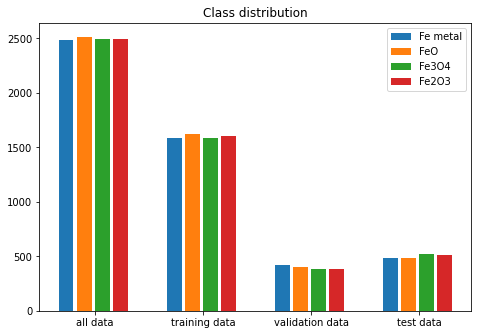

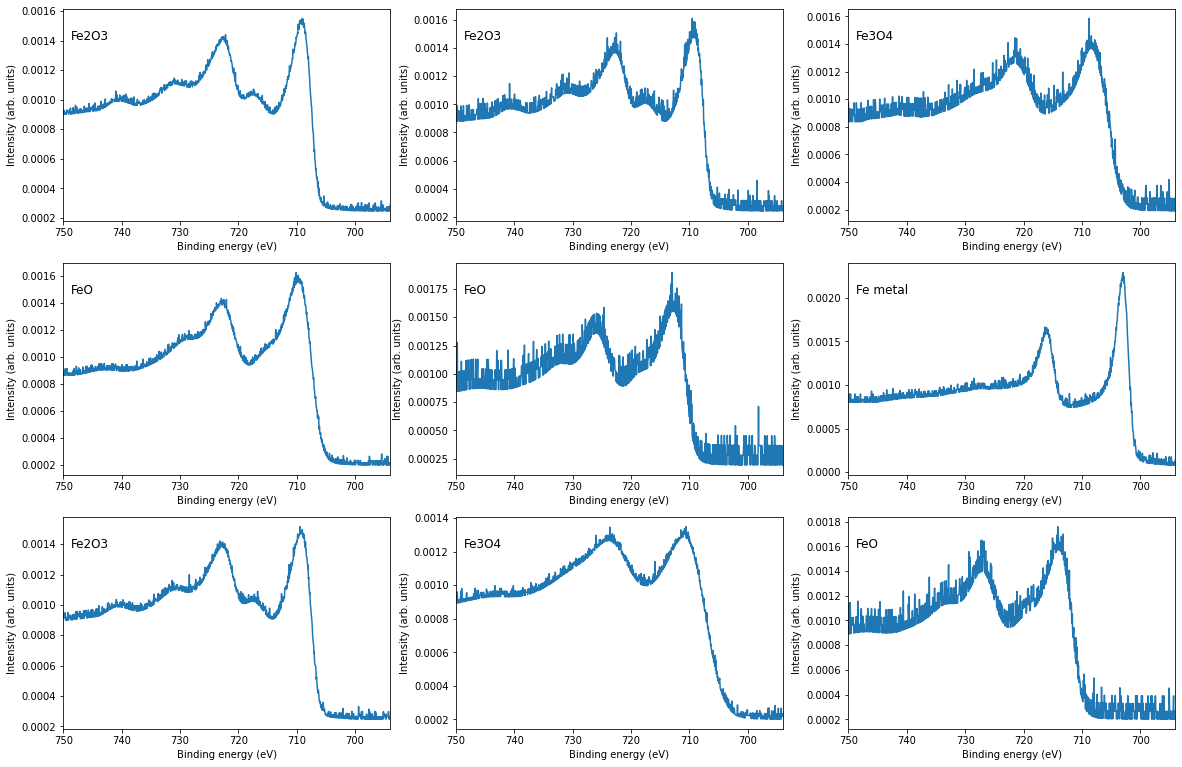

In [8]:
train_test_split = 0.2
train_val_split = 0.2
no_of_examples = 10000

X_train, X_val, X_test, y_train, y_val, y_test = \
        clf.load_data_preprocess(input_filepath = input_filepath,
                                 no_of_examples = no_of_examples,
                                 train_test_split = train_test_split,
                                 train_val_split = train_val_split)
        
# Check how the examples are distributed across the classes.
class_distribution = clf.check_class_distribution()
clf.plot_class_distribution()
clf.plot_random(no_of_spectra = 9, dataset = 'train')  

### Build the model

Model: "Custom_CNN_simple"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1113, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1105, 64)          18496     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 552, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 552, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 35328)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4522112   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)         

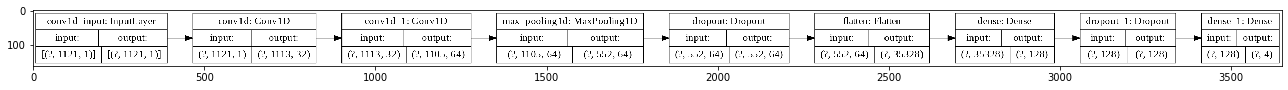

In [9]:
clf.build_model()
clf.summary()
clf.save_and_print_model_image()

### Training

In [10]:
epochs = 2
batch_size = 32

hist = clf.train(checkpoint = True,
                 early_stopping = False,
                 tb_log = True, 
                 csv_log = True,
                 epochs = epochs, 
                 batch_size = batch_size,
                 verbose = 1)

Train on 6400 samples, validate on 1600 samples
Epoch 1/2
 544/6400 [=>............................] - ETA: 43s - loss: 1.3863 - accuracy: 0.2676WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/app/saved_models/20200618_17h43m_Fe_single_4_classes_CNN_simple/assets
Saved model and hyperparameters.
Training interrupted!


### Graphs

In [ ]:
graph = TrainingGraphs(clf.history,
                        clf.model_name,
                        clf.time) 

### Evaluation on test data

In [ ]:
score = clf.evaluate()
test_loss, test_accuracy = score[0], score[1]
print('Test loss: ' + str(np.round(test_loss, decimals=3)))
print('Test accuracy: ' + str(np.round(test_accuracy, decimals=3)))

###  Prediction on test data

In [ ]:
pred_train, pred_test = clf.predict()
pred_train_classes, pred_test_classes = clf.predict_classes()

### Show some predictions

#### Training data

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'train', with_prediction = True)  

#### Test data

In [ ]:
clf.plot_random(no_of_spectra = 6, dataset = 'test', with_prediction = True)  

### Saving data

In [ ]:
clf.save_model()
clf.shelve_results(full = False)  

### Report

In [ ]:
dir_name = clf.time + '_' + clf.model_name
rep = Report(dir_name)  
rep.write()   